# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Set Matplotlib and Seaborn styles for better visualization
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Load the data

In [2]:
df = pd.read_csv('vendor_aging.csv')

# Prepare data for time series analysis (from previous notebooks)
def prepare_time_series_data(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID'):
    """
    Prepare vendor aging data for time series analysis by handling snapshot dates.
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Convert snapshot date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Convert last payment date to datetime if it exists
    if 'LP Date' in result_df.columns and not pd.api.types.is_datetime64_any_dtype(result_df['LP Date']):
        result_df['LP Date'] = pd.to_datetime(result_df['LP Date'], errors='coerce')

    # Sort data by vendor and date
    result_df = result_df.sort_values([vendor_id_col, snapshot_date_col])

    # Add a year-month column for easier grouping
    result_df['Year_Month'] = result_df[snapshot_date_col].dt.to_period('M')

    return result_df

def calculate_aging_metrics_over_time(df, snapshot_date_col='Snapshot_Date',
                                    aging_cols=None, vendor_id_col='Vendor ID'):
    """
    Calculate aging metrics for each vendor across snapshots.
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Calculate total aging for each snapshot
    result_df['Total_Aging'] = result_df[aging_cols].sum(axis=1)

    # Calculate aging beyond 90 days
    aging_beyond_90_cols = [col for col in aging_cols if '91' in col or '120' in col or
                           '180' in col or '360' in col or 'Above_361' in col]

    result_df['Aging_Beyond_90'] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Calculate aging percentages
    for col in aging_cols:
        result_df[f'{col}_Pct'] = (result_df[col] / result_df['Total_Aging'].replace(0, np.nan)) * 100
        result_df[f'{col}_Pct'] = result_df[f'{col}_Pct'].fillna(0)

    # Calculate percentage of aging beyond 90 days
    result_df['Pct_Aging_Beyond_90'] = (result_df['Aging_Beyond_90'] /
                                      result_df['Total_Aging'].replace(0, np.nan)) * 100
    result_df['Pct_Aging_Beyond_90'] = result_df['Pct_Aging_Beyond_90'].fillna(0)

    return result_df

def calculate_aging_trends(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                          aging_cols=None, window=3):
    """
    Calculate aging trends for each vendor over time.
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Calculate metrics over time
    result_df = calculate_aging_metrics_over_time(df, snapshot_date_col, aging_cols, vendor_id_col)

    # Group by vendor and sort by date for time series operations
    vendor_groups = result_df.groupby(vendor_id_col)

    # Initialize columns for trends
    trend_cols = ['Balance_MoM_Change', 'Aging_Beyond_90_MoM_Change',
                 'Balance_Trend', 'Aging_Beyond_90_Trend']

    for col in trend_cols:
        result_df[col] = np.nan

    # Calculate trends for each vendor
    for vendor_id, group in vendor_groups:
        # Sort by snapshot date
        vendor_data = group.sort_values(snapshot_date_col)

        if len(vendor_data) >= 2:  # Need at least 2 snapshots for trend
            # Calculate month-over-month changes
            vendor_data['Balance_MoM_Change'] = vendor_data['Balance Outstanding'].pct_change() * 100
            vendor_data['Aging_Beyond_90_MoM_Change'] = vendor_data['Aging_Beyond_90'].pct_change() * 100

            # Calculate rolling average trend if enough data points
            if len(vendor_data) >= window:
                # Simple linear regression slope would be better, but for simplicity:
                vendor_data['Balance_Trend'] = vendor_data['Balance Outstanding'].rolling(window=window).apply(
                    lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100 if x.iloc[0] != 0 else 0
                )

                vendor_data['Aging_Beyond_90_Trend'] = vendor_data['Aging_Beyond_90'].rolling(window=window).apply(
                    lambda x: (x.iloc[-1] - x.iloc[0]) / (x.iloc[0] or 1) * 100
                )

            # Update the main dataframe with trend calculations
            result_df.loc[vendor_data.index, 'Balance_MoM_Change'] = vendor_data['Balance_MoM_Change']
            result_df.loc[vendor_data.index, 'Aging_Beyond_90_MoM_Change'] = vendor_data['Aging_Beyond_90_MoM_Change']
            result_df.loc[vendor_data.index, 'Balance_Trend'] = vendor_data['Balance_Trend']
            result_df.loc[vendor_data.index, 'Aging_Beyond_90_Trend'] = vendor_data['Aging_Beyond_90_Trend']

    # Categorize the trends
    result_df['Balance_Trend_Category'] = pd.cut(
        result_df['Balance_Trend'],
        bins=[-float('inf'), -10, -3, 3, 10, float('inf')],
        labels=['Rapidly Decreasing', 'Decreasing', 'Stable', 'Increasing', 'Rapidly Increasing']
    )

    result_df['Aging_Trend_Category'] = pd.cut(
        result_df['Aging_Beyond_90_Trend'],
        bins=[-float('inf'), -10, -3, 3, 10, float('inf')],
        labels=['Rapidly Improving', 'Improving', 'Stable', 'Worsening', 'Rapidly Worsening']
    )

    return result_df

# Apply the preliminary functions
prepared_df = prepare_time_series_data(df)
metrics_df = calculate_aging_metrics_over_time(prepared_df)
trends_df = calculate_aging_trends(metrics_df)

print("Data prepared with basic metrics and trends. Now performing vendor comparison and cohort analysis...")


Data prepared with basic metrics and trends. Now performing vendor comparison and cohort analysis...


# Create vendor cohorts

In [3]:
def create_vendor_cohorts(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                        aging_cols=None, n_clusters=4):
    """
    Create vendor cohorts based on aging patterns over time.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        aging_cols (list): List of aging bucket columns
        n_clusters (int): Number of clusters/cohorts to create

    Returns:
        tuple: (DataFrame with cohort assignments, cohort profiles)
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Calculate metrics over time
    result_df = calculate_aging_metrics_over_time(df, snapshot_date_col, aging_cols, vendor_id_col)

    # Add trend metrics
    result_df = calculate_aging_trends(result_df, snapshot_date_col, vendor_id_col, aging_cols)

    # Get the latest snapshot for each vendor for cohort assignment
    latest_snapshots = result_df.sort_values(snapshot_date_col).groupby(vendor_id_col).last().reset_index()

    # Create features for clustering
    features = [
        'Pct_Aging_Beyond_90',  # Current aging percentage
        'Aging_Beyond_90_Trend'  # Trend in aging
    ]

    # Add aging bucket percentages
    for col in aging_cols:
        pct_col = f'{col}_Pct'
        if pct_col in latest_snapshots.columns:
            features.append(pct_col)

    # Prepare feature matrix
    X = latest_snapshots[features].fillna(0)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cohort_labels = kmeans.fit_predict(X_scaled)

    # Add cohort labels to the latest snapshot data
    latest_snapshots['Cohort'] = cohort_labels

    # Create cohort profiles
    cohort_profiles = {}
    for i in range(n_clusters):
        cohort_vendors = latest_snapshots[latest_snapshots['Cohort'] == i]

        # Calculate key metrics for this cohort
        profile = {
            'size': len(cohort_vendors),
            'avg_balance': cohort_vendors['Balance Outstanding'].mean(),
            'avg_aging_beyond_90': cohort_vendors['Aging_Beyond_90'].mean(),
            'avg_pct_aging_beyond_90': cohort_vendors['Pct_Aging_Beyond_90'].mean(),
            'avg_trend': cohort_vendors['Aging_Beyond_90_Trend'].mean()
        }

        # Assign a descriptive label
        trend_direction = "Improving" if profile['avg_trend'] < 0 else "Worsening"
        aging_level = "High Aging" if profile['avg_pct_aging_beyond_90'] > 30 else "Low Aging"

        profile['label'] = f"Cohort {i+1}: {aging_level}, {trend_direction}"
        cohort_profiles[i] = profile

    # Map cohort back to all snapshots
    vendor_cohort_map = latest_snapshots[[vendor_id_col, 'Cohort']].set_index(vendor_id_col)['Cohort'].to_dict()
    result_df['Cohort'] = result_df[vendor_id_col].map(vendor_cohort_map)

    # Map labels
    cohort_labels_map = {i: profile['label'] for i, profile in cohort_profiles.items()}
    result_df['Cohort_Label'] = result_df['Cohort'].map(cohort_labels_map)

    return result_df, cohort_profiles


In [4]:
cohort_df, cohort_profiles = create_vendor_cohorts(trends_df)

# Display the cohort profiles
print("\nCohort profiles:")
for cohort_id, profile in cohort_profiles.items():
    print(f"\nCohort {cohort_id} - {profile['label']}:")
    print(f"  Size: {profile['size']} vendors")
    print(f"  Average Balance: ${profile['avg_balance']:,.2f}")
    print(f"  Average Aging Beyond 90: ${profile['avg_aging_beyond_90']:,.2f}")
    print(f"  Average % Aging Beyond 90: {profile['avg_pct_aging_beyond_90']:.2f}%")
    print(f"  Average Trend: {profile['avg_trend']:.2f}%")


Cohort profiles:

Cohort 0 - Cohort 1: High Aging, Worsening:
  Size: 89 vendors
  Average Balance: $1,400,942.12
  Average Aging Beyond 90: $919,737.40
  Average % Aging Beyond 90: 64.62%
  Average Trend: 33.87%

Cohort 1 - Cohort 2: Low Aging, Improving:
  Size: 12 vendors
  Average Balance: $385,859.40
  Average Aging Beyond 90: $0.00
  Average % Aging Beyond 90: 0.00%
  Average Trend: -8.33%

Cohort 2 - Cohort 3: High Aging, Worsening:
  Size: 48 vendors
  Average Balance: $823,936.22
  Average Aging Beyond 90: $446,351.74
  Average % Aging Beyond 90: 50.61%
  Average Trend: 77.50%

Cohort 3 - Cohort 4: Low Aging, Worsening:
  Size: 1 vendors
  Average Balance: $287,376.28
  Average Aging Beyond 90: $21,329.90
  Average % Aging Beyond 90: 7.04%
  Average Trend: 2132990.00%


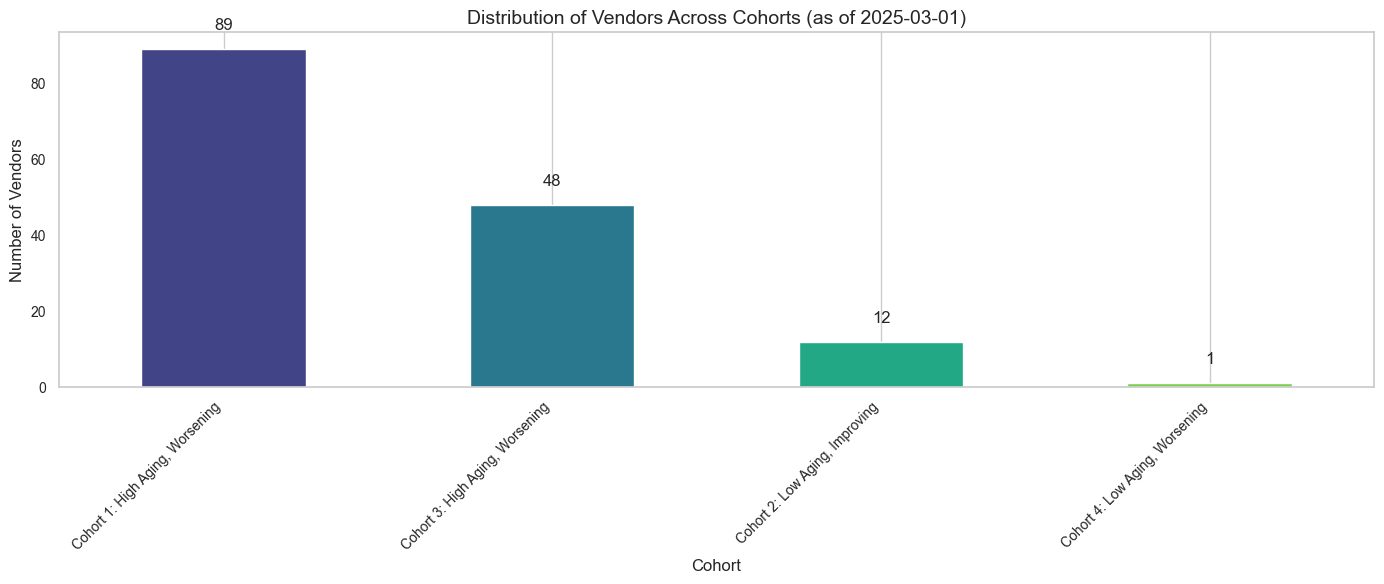

In [6]:
# Visualize cohort distribution
latest_date = cohort_df['Snapshot_Date'].max()
latest_cohort = cohort_df[cohort_df['Snapshot_Date'] == latest_date]

cohort_counts = latest_cohort['Cohort_Label'].value_counts()

plt.figure(figsize=(14, 6))
ax = cohort_counts.plot(kind='bar', color=sns.color_palette("viridis", len(cohort_counts)))
plt.title(f'Distribution of Vendors Across Cohorts (as of {latest_date.strftime("%Y-%m-%d")})')
plt.xlabel('Cohort')
plt.ylabel('Number of Vendors')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Add count labels on top of bars
for i, v in enumerate(cohort_counts):
    ax.text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

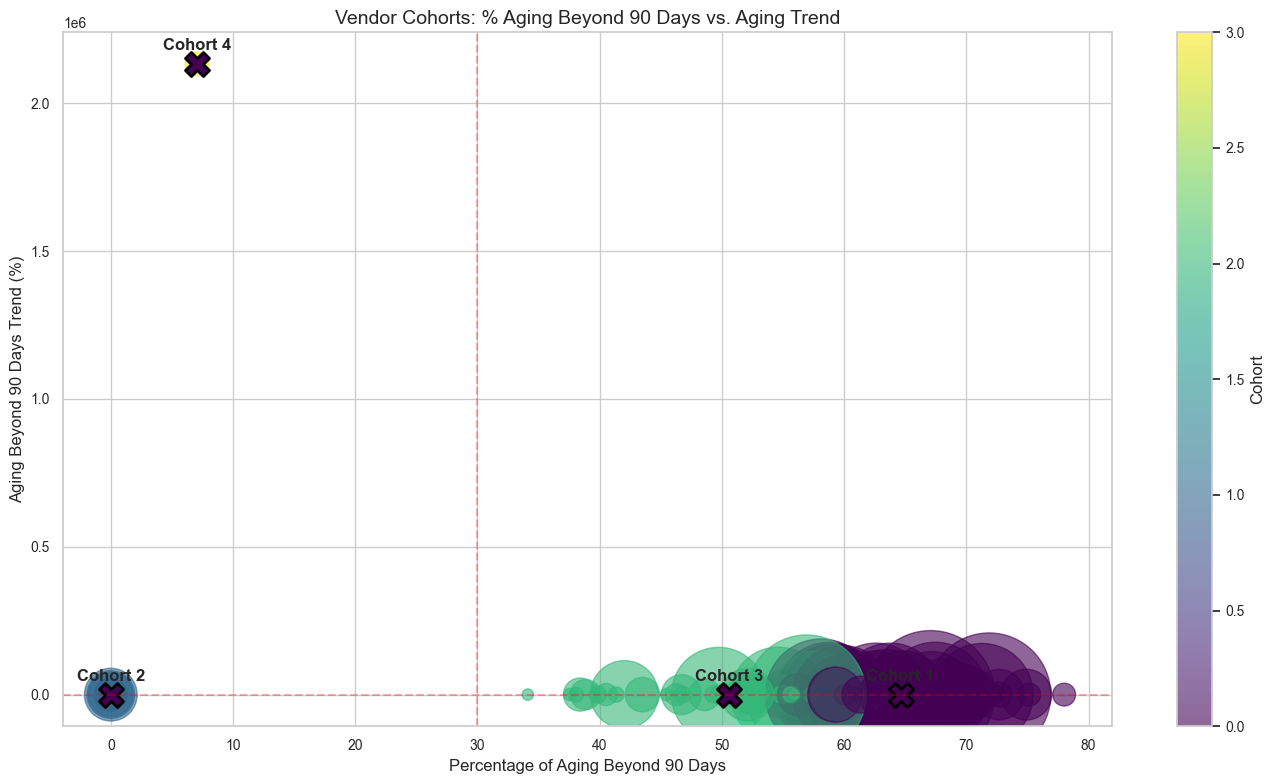

In [7]:
# Visualize cohorts using key metrics
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    latest_cohort['Pct_Aging_Beyond_90'], 
    latest_cohort['Aging_Beyond_90_Trend'], 
    c=latest_cohort['Cohort'], 
    s=latest_cohort['Balance Outstanding'] / 1000,  # Size proportional to balance
    alpha=0.6,
    cmap='viridis'
)

# Add cluster centers
for cohort_id, profile in cohort_profiles.items():
    plt.scatter(
        profile['avg_pct_aging_beyond_90'],
        profile['avg_trend'],
        s=300,
        c=[cohort_id],
        cmap='viridis',
        marker='X',
        edgecolors='black',
        linewidth=2
    )
    plt.annotate(
        f"Cohort {cohort_id+1}",
        (profile['avg_pct_aging_beyond_90'], profile['avg_trend']),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontweight='bold'
    )

plt.colorbar(scatter, label='Cohort')
plt.title('Vendor Cohorts: % Aging Beyond 90 Days vs. Aging Trend')
plt.xlabel('Percentage of Aging Beyond 90 Days')
plt.ylabel('Aging Beyond 90 Days Trend (%)')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=30, color='red', linestyle='--', alpha=0.3)
plt.grid(True)
plt.tight_layout()
plt.show()

# Compare vendor to peers

In [8]:
def compare_vendor_to_peers(df, target_vendor_id, snapshot_date_col='Snapshot_Date',
                          vendor_id_col='Vendor ID', metrics=None,
                          latest_only=True, percentile=True):
    """
    Compare a specific vendor against peers over time.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        target_vendor_id: ID of the vendor to compare
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        metrics (list): List of metrics to compare
        latest_only (bool): Whether to compare only the latest snapshot
        percentile (bool): Whether to return percentile rankings

    Returns:
        pandas.DataFrame or dict: Comparison results
    """
    # Define default metrics if not specified
    if metrics is None:
        metrics = [
            'Balance Outstanding', 'Aging_Beyond_90', 'Pct_Aging_Beyond_90',
            'Balance_Trend', 'Aging_Beyond_90_Trend'
        ]

    # Ensure we have required metrics
    if 'Aging_Beyond_90' not in df.columns:
        df = calculate_aging_metrics_over_time(df)

    if 'Balance_Trend' not in df.columns:
        df = calculate_aging_trends(df)

    # Create a copy to work with
    result_df = df.copy()

    # Filter to specific vendor
    target_vendor_data = result_df[result_df[vendor_id_col] == target_vendor_id]

    if latest_only:
        # Get only the latest snapshot for each vendor
        latest_snapshot = result_df.sort_values(snapshot_date_col).groupby(vendor_id_col).last().reset_index()

        # Get the latest date for the target vendor
        if not target_vendor_data.empty:
            latest_target_date = target_vendor_data[snapshot_date_col].max()
            target_data = target_vendor_data[target_vendor_data[snapshot_date_col] == latest_target_date]

            # Calculate comparison metrics
            comparison = {}

            for metric in metrics:
                if metric in latest_snapshot.columns:
                    # Get target vendor's value
                    target_value = target_data[metric].iloc[0] if not target_data.empty else None

                    if target_value is not None:
                        # Calculate peer statistics
                        peer_mean = latest_snapshot[metric].mean()
                        peer_median = latest_snapshot[metric].median()
                        peer_std = latest_snapshot[metric].std()

                        # Calculate percentile if requested
                        if percentile:
                            percentile_rank = (latest_snapshot[metric] < target_value).mean() * 100
                        else:
                            percentile_rank = None

                        comparison[metric] = {
                            'target_value': target_value,
                            'peer_mean': peer_mean,
                            'peer_median': peer_median,
                            'peer_std': peer_std,
                            'percentile_rank': percentile_rank,
                            'difference_from_mean': target_value - peer_mean,
                            'standard_deviations_from_mean': (target_value - peer_mean) / peer_std if peer_std > 0 else 0
                        }

            return comparison
    else:
        # Compare across all snapshots
        comparison_by_snapshot = {}

        for snapshot_date, snapshot_group in result_df.groupby(snapshot_date_col):
            # Check if target vendor exists in this snapshot
            target_in_snapshot = target_vendor_data[target_vendor_data[snapshot_date_col] == snapshot_date]

            if not target_in_snapshot.empty:
                # Calculate comparison for this snapshot
                snapshot_comparison = {}

                for metric in metrics:
                    if metric in snapshot_group.columns:
                        # Get target vendor's value
                        target_value = target_in_snapshot[metric].iloc[0]

                        # Calculate peer statistics
                        peer_mean = snapshot_group[metric].mean()
                        peer_median = snapshot_group[metric].median()
                        peer_std = snapshot_group[metric].std()

                        # Calculate percentile if requested
                        if percentile:
                            percentile_rank = (snapshot_group[metric] < target_value).mean() * 100
                        else:
                            percentile_rank = None

                        snapshot_comparison[metric] = {
                            'target_value': target_value,
                            'peer_mean': peer_mean,
                            'peer_median': peer_median,
                            'peer_std': peer_std,
                            'percentile_rank': percentile_rank,
                            'difference_from_mean': target_value - peer_mean,
                            'standard_deviations_from_mean': (target_value - peer_mean) / peer_std if peer_std > 0 else 0
                        }

                comparison_by_snapshot[snapshot_date] = snapshot_comparison

        return comparison_by_snapshot

In [9]:
latest_date = cohort_df['Snapshot_Date'].max()
latest_data = cohort_df[cohort_df['Snapshot_Date'] == latest_date]
target_vendor = latest_data.nlargest(5, 'Aging_Beyond_90').iloc[0]
target_vendor_id = target_vendor['Vendor ID']
target_vendor_name = target_vendor['Vendor']

In [10]:
print(f"\nComparing vendor {target_vendor_name} (ID: {target_vendor_id}) to peers:")


Comparing vendor Michelle Graham (ID: 92) to peers:



Balance Outstanding:
  Target Value: 8,499,405.23
  Peer Mean: 1,127,669.84
  Difference from Mean: 7,371,735.39
  Percentile Rank: 99.3%
  Standard Deviations from Mean: 4.22

Aging_Beyond_90:
  Target Value: 5,790,375.43
  Peer Mean: 688,685.61
  Difference from Mean: 5,101,689.82
  Percentile Rank: 99.3%
  Standard Deviations from Mean: 4.49

Pct_Aging_Beyond_90:
  Target Value: 67.07
  Peer Mean: 54.58
  Difference from Mean: 12.49
  Percentile Rank: 84.0%
  Standard Deviations from Mean: 0.67

Balance_Trend:
  Target Value: 17.34
  Peer Mean: 20.58
  Difference from Mean: -3.24
  Percentile Rank: 23.3%
  Standard Deviations from Mean: -0.24

Aging_Beyond_90_Trend:
  Target Value: 31.50
  Peer Mean: 14,264.16
  Difference from Mean: -14,232.66
  Percentile Rank: 32.7%
  Standard Deviations from Mean: -0.08


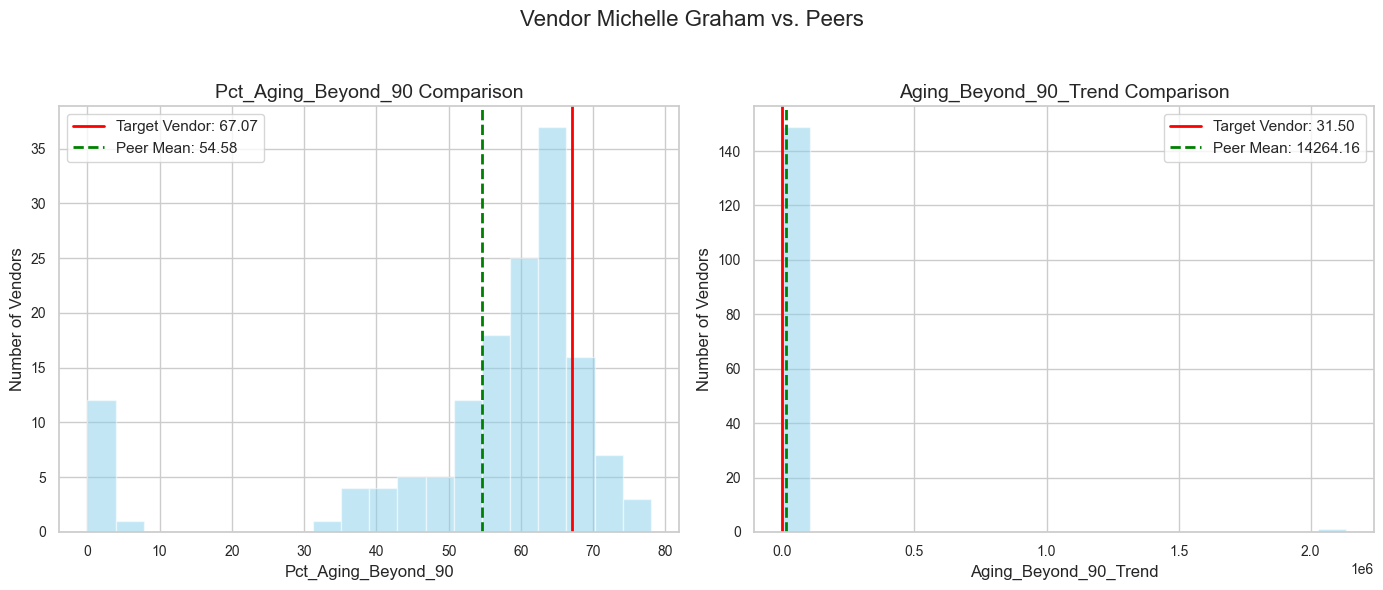

In [11]:

# Get latest snapshot comparison
latest_comparison = compare_vendor_to_peers(cohort_df, target_vendor_id)

# Display the comparison results
for metric, results in latest_comparison.items():
    print(f"\n{metric}:")
    print(f"  Target Value: {results['target_value']:,.2f}")
    print(f"  Peer Mean: {results['peer_mean']:,.2f}")
    print(f"  Difference from Mean: {results['difference_from_mean']:,.2f}")
    print(f"  Percentile Rank: {results['percentile_rank']:.1f}%")
    print(f"  Standard Deviations from Mean: {results['standard_deviations_from_mean']:.2f}")

# Visualize the comparison
metrics_to_plot = ['Pct_Aging_Beyond_90', 'Aging_Beyond_90_Trend']
plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 2, i+1)
    
    # Create a histogram of all vendors
    plt.hist(latest_data[metric], bins=20, alpha=0.5, color='skyblue')
    
    # Add lines for the target vendor and mean
    plt.axvline(x=latest_comparison[metric]['target_value'], color='red', linestyle='-', linewidth=2, 
                label=f"Target Vendor: {latest_comparison[metric]['target_value']:.2f}")
    plt.axvline(x=latest_comparison[metric]['peer_mean'], color='green', linestyle='--', linewidth=2, 
                label=f"Peer Mean: {latest_comparison[metric]['peer_mean']:.2f}")
    
    plt.title(f'{metric} Comparison')
    plt.xlabel(metric)
    plt.ylabel('Number of Vendors')
    plt.legend()
    plt.grid(True)

plt.suptitle(f'Vendor {target_vendor_name} vs. Peers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
plt.show()


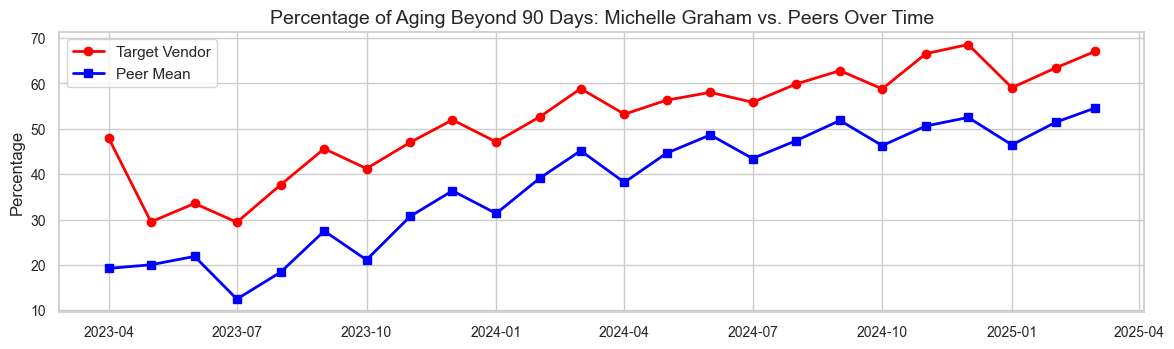

In [12]:
# Get comparison over time
time_comparison = compare_vendor_to_peers(cohort_df, target_vendor_id, latest_only=False)

# Prepare data for time series plot
dates = list(time_comparison.keys())
target_values = [time_comparison[date]['Pct_Aging_Beyond_90']['target_value'] for date in dates]
peer_means = [time_comparison[date]['Pct_Aging_Beyond_90']['peer_mean'] for date in dates]
percentiles = [time_comparison[date]['Pct_Aging_Beyond_90']['percentile_rank'] for date in dates]

# Visualize the comparison over time
plt.figure(figsize=(14, 8))

# Plot 1: Target vs Peer Mean
ax1 = plt.subplot(2, 1, 1)
plt.plot(dates, target_values, marker='o', color='red', linewidth=2, label='Target Vendor')
plt.plot(dates, peer_means, marker='s', color='blue', linewidth=2, label='Peer Mean')
plt.title(f'Percentage of Aging Beyond 90 Days: {target_vendor_name} vs. Peers Over Time')
plt.ylabel('Percentage')
plt.grid(True)
plt.legend()

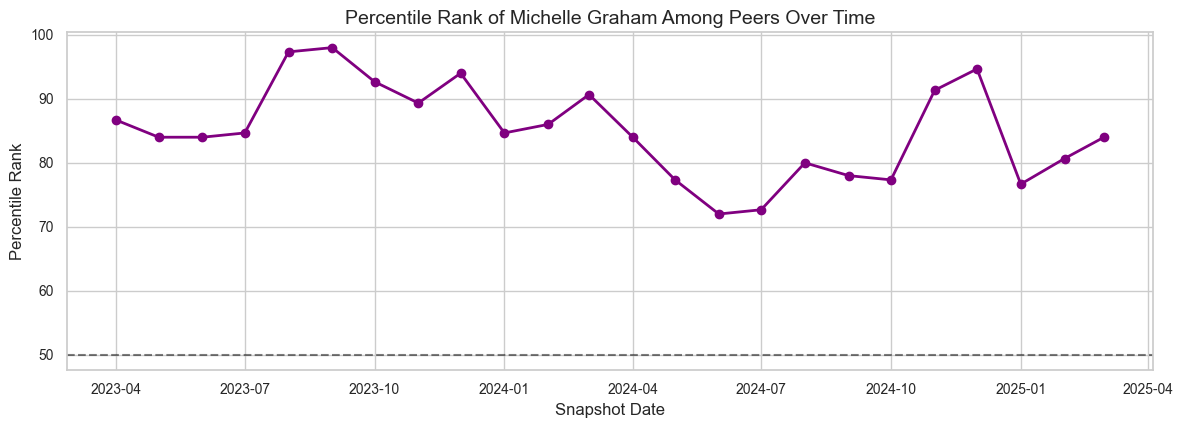

In [13]:
# Plot 2: Percentile Rank
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(dates, percentiles, marker='o', color='purple', linewidth=2)
plt.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Median (50th Percentile)')
plt.title(f'Percentile Rank of {target_vendor_name} Among Peers Over Time')
plt.xlabel('Snapshot Date')
plt.ylabel('Percentile Rank')
plt.grid(True)
plt.tight_layout()
plt.show()

# Aging waterfall analysis

In [14]:
def aging_waterfall_analysis(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                           aging_cols=None, include_total=True):
    """
    Create a waterfall analysis showing how aging buckets shift between snapshots.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        aging_cols (list): List of aging bucket columns in chronological order
        include_total (bool): Whether to include total balance in the analysis

    Returns:
        dict: Waterfall analysis results by vendor
    """
    # Define default aging columns if not specified (in chronological order)
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Ensure date column is datetime
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Add balance column to aging columns if requested
    analysis_cols = aging_cols.copy()
    if include_total:
        analysis_cols.append('Balance Outstanding')

    # Results container
    waterfall_results = {}

    # Analyze each vendor
    for vendor_id, group in result_df.groupby(vendor_id_col):
        # Sort by snapshot date
        vendor_data = group.sort_values(snapshot_date_col)

        # Need at least two snapshots for waterfall analysis
        if len(vendor_data) >= 2:
            # Store transitions between snapshots
            transitions = []

            for i in range(1, len(vendor_data)):
                prev_snapshot = vendor_data.iloc[i-1]
                curr_snapshot = vendor_data.iloc[i]

                prev_date = prev_snapshot[snapshot_date_col]
                curr_date = curr_snapshot[snapshot_date_col]

                # Calculate changes in each bucket
                changes = {}

                for col in analysis_cols:
                    prev_value = prev_snapshot[col]
                    curr_value = curr_snapshot[col]
                    changes[col] = curr_value - prev_value

                # Calculate implied bucket transitions
                # (This is a simplified approximation since we don't have actual cash flows)
                bucket_transitions = {}

                # For each aging bucket (except the last one)
                for j in range(len(aging_cols) - 1):
                    from_bucket = aging_cols[j]
                    to_bucket = aging_cols[j+1]

                    # Estimate amount that moved from one bucket to the next
                    # This is a very rough approximation
                    implied_flow = min(prev_snapshot[from_bucket], curr_snapshot[to_bucket])
                    bucket_transitions[f'{from_bucket}_to_{to_bucket}'] = implied_flow

                transitions.append({
                    'from_date': prev_date,
                    'to_date': curr_date,
                    'days_between': (curr_date - prev_date).days,
                    'changes': changes,
                    'implied_transitions': bucket_transitions
                })

            waterfall_results[vendor_id] = {
                'transitions': transitions,
                'latest_snapshot': vendor_data.iloc[-1][analysis_cols].to_dict(),
                'first_snapshot': vendor_data.iloc[0][analysis_cols].to_dict(),
                'total_change': {
                    col: vendor_data.iloc[-1][col] - vendor_data.iloc[0][col]
                    for col in analysis_cols
                }
            }

    return waterfall_results

In [15]:
waterfall_analysis = aging_waterfall_analysis(cohort_df, vendor_id_col='Vendor ID')


Waterfall Analysis for Michelle Graham (ID: 92):

Total change from first to latest snapshot:
  Future_Aging: $-117,294.53
  Aging_0_30: $264,216.65
  Aging_31_60: $217,018.08
  Aging_61_90: $389,782.23
  Aging_91_120: $-711,216.20
  Aging_121_180: $986,503.43
  Aging_181_360: $913,536.29
  Above_361_Aging: $2,675,339.84
  Balance Outstanding: $6,048,721.42

Snapshot-to-snapshot transitions:

Transition 1: 2023-04-01 to 2023-05-01 (30 days)
  Significant changes:
    Future_Aging: $157,484.72 decrease
    Aging_0_30: $84,697.00 increase
    Aging_31_60: $129,298.08 increase
    Aging_61_90: $63,347.38 increase
    Aging_91_120: $1,257,312.96 decrease
    Aging_121_180: $159,697.91 increase
    Aging_181_360: $45,226.80 increase
    Above_361_Aging: $50,259.95 increase
    Balance Outstanding: $588,755.27 increase
  Implied bucket transitions:
    Future_Aging → Aging_0_30: $250,861.09
    Aging_0_30 → Aging_31_60: $735,205.14
    Aging_31_60 → Aging_61_90: $553,484.14
    Aging_61_90 

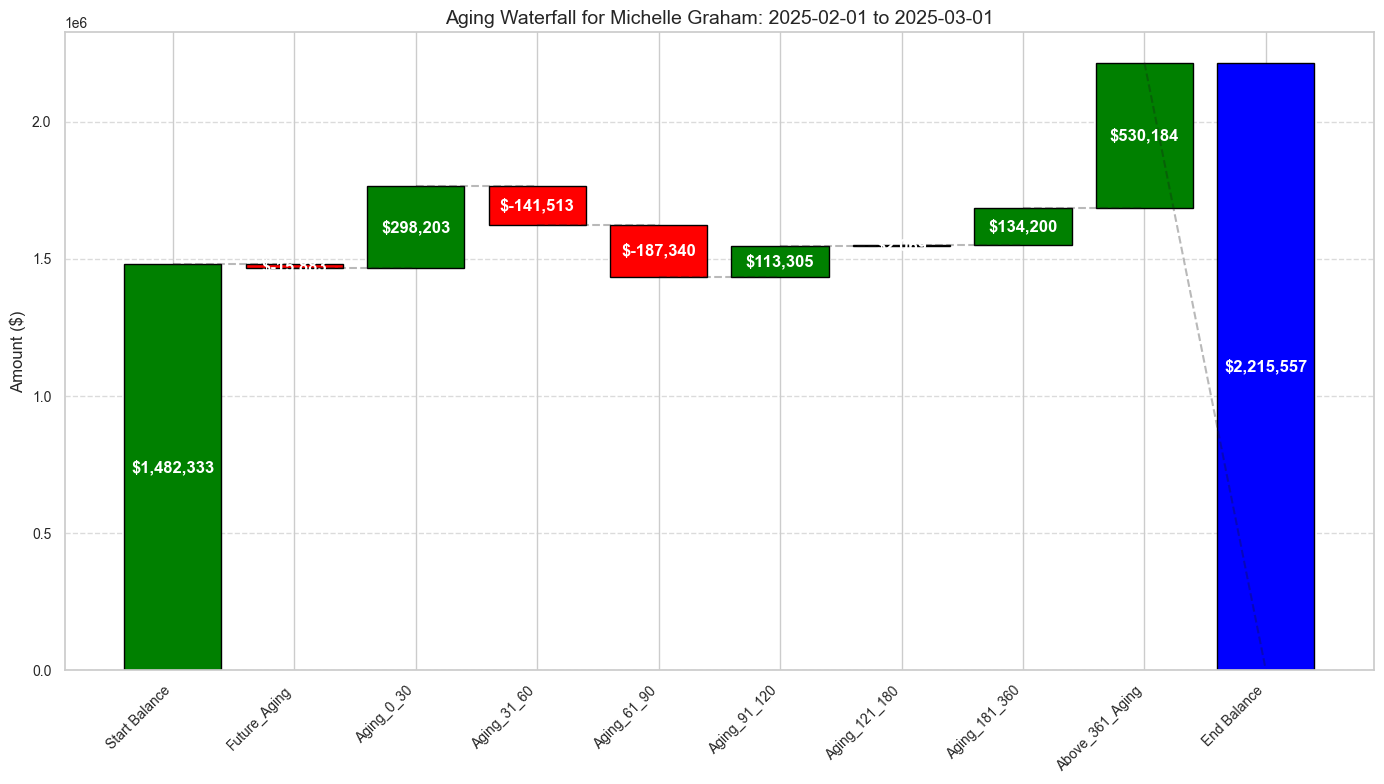

In [16]:
if target_vendor_id in waterfall_analysis:
    vendor_waterfall = waterfall_analysis[target_vendor_id]
    
    print(f"\nWaterfall Analysis for {target_vendor_name} (ID: {target_vendor_id}):")
    
    # Display total change across all snapshots
    print("\nTotal change from first to latest snapshot:")
    for bucket, change in vendor_waterfall['total_change'].items():
        print(f"  {bucket}: ${change:,.2f}")
    
    # Analyze transitions
    print("\nSnapshot-to-snapshot transitions:")
    for i, transition in enumerate(vendor_waterfall['transitions']):
        from_date = transition['from_date'].strftime('%Y-%m-%d') if hasattr(transition['from_date'], 'strftime') else transition['from_date']
        to_date = transition['to_date'].strftime('%Y-%m-%d') if hasattr(transition['to_date'], 'strftime') else transition['to_date']
        
        print(f"\nTransition {i+1}: {from_date} to {to_date} ({transition['days_between']} days)")
        
        # Show major changes
        significant_changes = {k: v for k, v in transition['changes'].items() if abs(v) > 100}
        if significant_changes:
            print("  Significant changes:")
            for bucket, change in significant_changes.items():
                direction = "increase" if change > 0 else "decrease"
                print(f"    {bucket}: ${abs(change):,.2f} {direction}")
        
        # Show major implied transitions
        significant_transitions = {k: v for k, v in transition['implied_transitions'].items() if v > 100}
        if significant_transitions:
            print("  Implied bucket transitions:")
            for transition_key, amount in significant_transitions.items():
                from_bucket, to_bucket = transition_key.split('_to_')
                print(f"    {from_bucket} → {to_bucket}: ${amount:,.2f}")
    
    # Visualize the waterfall for the latest transition
    if vendor_waterfall['transitions']:
        latest_transition = vendor_waterfall['transitions'][-1]
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]
        
        # Prepare data for waterfall chart
        labels = []
        values = []
        colors = []
        
        # Start value
        labels.append('Start Balance')
        start_balance = sum(latest_transition['changes'].values())
        values.append(start_balance)
        colors.append('green')
        
        # Bucket changes
        for bucket in aging_cols:
            if bucket in latest_transition['changes']:
                change = latest_transition['changes'][bucket]
                if abs(change) > 0:  # Only show non-zero changes
                    labels.append(bucket)
                    values.append(change)
                    colors.append('green' if change > 0 else 'red')
        
        # End value
        labels.append('End Balance')
        values.append(0)  # Zero so it doesn't affect the waterfall
        colors.append('blue')
        
        # Create the waterfall chart
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Calculate positions for bars
        cumulative_sum = 0
        bottoms = []
        for v in values[:-1]:  # Skip the last value (end balance)
            bottoms.append(cumulative_sum)
            cumulative_sum += v
        
        # Adjust the last value (end balance)
        bottoms.append(0)
        values[-1] = cumulative_sum
        
        # Plot bars
        bars = ax.bar(labels, values, bottom=bottoms, color=colors, edgecolor='black')
        
        # Connect bars with lines
        prev_x = 0
        prev_y = values[0]
        for i in range(1, len(labels)):
            x = i
            y = bottoms[i] + values[i] if i < len(values) - 1 else values[i]
            plt.plot([prev_x, x], [prev_y, bottoms[i]], 'k--', alpha=0.3)
            prev_x = x
            prev_y = y
        
        # Add value labels on the bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height != 0:
                value_text = f"${values[i]:,.0f}"
                if values[i] > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., bottoms[i] + height/2, value_text,
                           ha='center', va='center', color='white', fontweight='bold')
                else:
                    ax.text(bar.get_x() + bar.get_width()/2., bottoms[i] + height/2, value_text,
                           ha='center', va='center', color='white', fontweight='bold')
        
        # Format and display
        from_date = latest_transition['from_date'].strftime('%Y-%m-%d') if hasattr(latest_transition['from_date'], 'strftime') else latest_transition['from_date']
        to_date = latest_transition['to_date'].strftime('%Y-%m-%d') if hasattr(latest_transition['to_date'], 'strftime') else latest_transition['to_date']
        plt.title(f'Aging Waterfall for {target_vendor_name}: {from_date} to {to_date}')
        plt.ylabel('Amount ($)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Snapshot comparison analysis

In [17]:
def snapshot_comparison_analysis(df, snapshot_date_col='Snapshot_Date',
                               base_date=None, compare_date=None,
                               aging_cols=None, vendor_id_col='Vendor ID'):
    """
    Compare aging metrics between two snapshots.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        base_date: Base snapshot date (if None, uses earliest date)
        compare_date: Comparison snapshot date (if None, uses latest date)
        aging_cols (list): List of aging bucket columns
        vendor_id_col (str): Column containing vendor identifier

    Returns:
        pandas.DataFrame: DataFrame with snapshot comparison metrics
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Ensure date column is datetime
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Determine base and comparison dates if not provided
    if base_date is None:
        base_date = result_df[snapshot_date_col].min()

    if compare_date is None:
        compare_date = result_df[snapshot_date_col].max()

    # Convert dates to datetime if they're not already
    base_date = pd.to_datetime(base_date)
    compare_date = pd.to_datetime(compare_date)

    # Create Aging_Beyond_90 column if it doesn't exist
    if 'Aging_Beyond_90' not in result_df.columns:
        aging_beyond_90_cols = [col for col in aging_cols if '91' in col or '120' in col or
                               '180' in col or '360' in col or 'Above_361' in col]
        result_df['Aging_Beyond_90'] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Get data for base and comparison dates
    base_data = result_df[result_df[snapshot_date_col] == base_date]
    compare_data = result_df[result_df[snapshot_date_col] == compare_date]

    # Create pivot for easy comparison
    comparison_columns = ['Balance Outstanding', 'Aging_Beyond_90'] + aging_cols

    # Create a merged dataframe for comparison
    base_subset = base_data[[vendor_id_col] + comparison_columns].set_index(vendor_id_col)
    base_subset.columns = [f'{col}_Base' for col in base_subset.columns]

    compare_subset = compare_data[[vendor_id_col] + comparison_columns].set_index(vendor_id_col)
    compare_subset.columns = [f'{col}_Compare' for col in compare_subset.columns]

    # Merge the data
    comparison_df = base_subset.join(compare_subset, how='outer')

    # Calculate changes
    for col in comparison_columns:
        base_col = f'{col}_Base'
        compare_col = f'{col}_Compare'
        change_col = f'{col}_Change'
        pct_change_col = f'{col}_Pct_Change'

        comparison_df[change_col] = comparison_df[compare_col] - comparison_df[base_col]

        # Calculate percentage change, handling division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            pct_change = (comparison_df[compare_col] - comparison_df[base_col]) / comparison_df[base_col].abs() * 100
            comparison_df[pct_change_col] = np.where(
                comparison_df[base_col] == 0,
                np.nan,
                pct_change
            )

    # Reset index to make vendor ID a regular column
    comparison_df = comparison_df.reset_index()

    # Add a direction column for key metrics
    for col in ['Balance Outstanding', 'Aging_Beyond_90']:
        comparison_df[f'{col}_Direction'] = np.where(
            comparison_df[f'{col}_Change'] > 0,
            'Increased',
            np.where(
                comparison_df[f'{col}_Change'] < 0,
                'Decreased',
                'Unchanged'
            )
        )

    return comparison_df


Snapshot Comparison Analysis: 2023-04-01 vs. 2025-03-01

Overall changes:
  Total Balance Change: $129,682,399.98
  Total Aging Beyond 90 Change: $94,273,915.31

Vendor counts by direction:
  Balance Increased: 144
  Balance Decreased: 6
  Aging Beyond 90 Increased: 138
  Aging Beyond 90 Decreased: 12


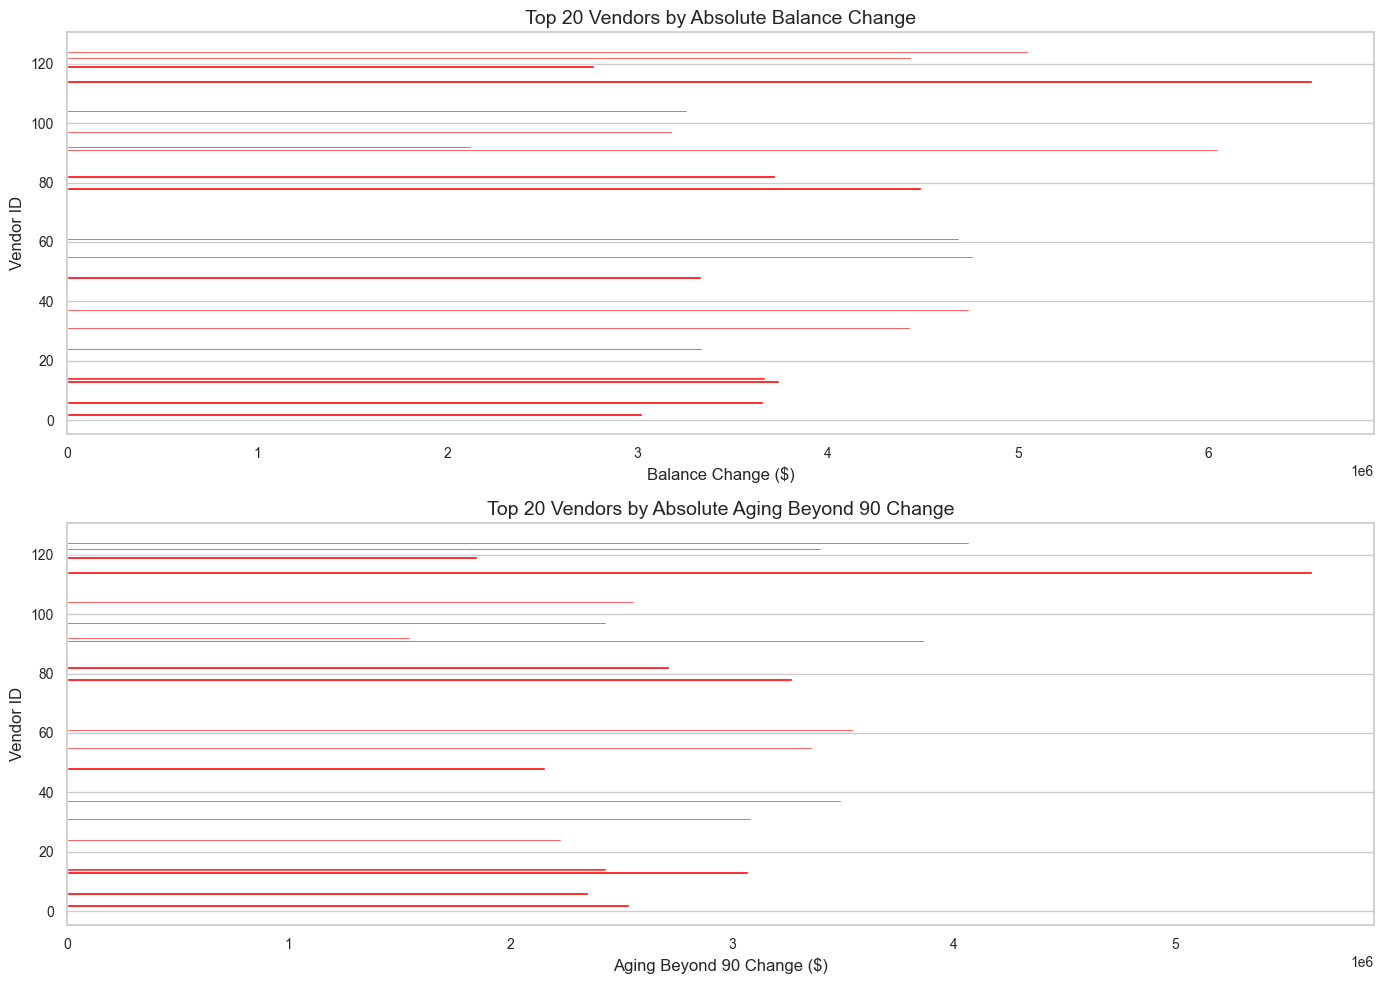

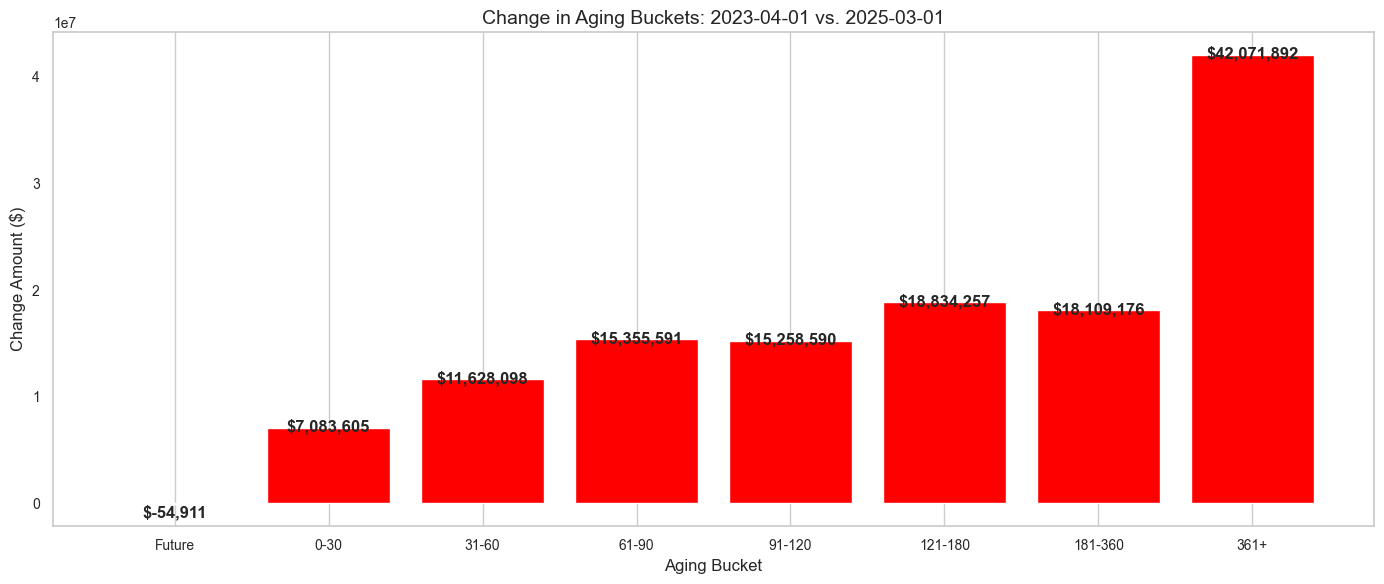

In [19]:
# Apply the function to compare earliest vs. latest snapshot
snapshot_dates = sorted(cohort_df['Snapshot_Date'].unique())
if len(snapshot_dates) >= 2:
    # Get first and last dates
    first_date = snapshot_dates[0]
    last_date = snapshot_dates[-1]
    
    # Run the comparison
    snapshot_comparison = snapshot_comparison_analysis(
        cohort_df, 
        base_date=first_date, 
        compare_date=last_date
    )
    
    print(f"\nSnapshot Comparison Analysis: {first_date.strftime('%Y-%m-%d')} vs. {last_date.strftime('%Y-%m-%d')}")
    
    # Summarize overall changes
    print("\nOverall changes:")
    total_balance_change = snapshot_comparison['Balance Outstanding_Change'].sum()
    total_aging_beyond_90_change = snapshot_comparison['Aging_Beyond_90_Change'].sum()
    
    print(f"  Total Balance Change: ${total_balance_change:,.2f}")
    print(f"  Total Aging Beyond 90 Change: ${total_aging_beyond_90_change:,.2f}")
    
    # Count direction changes
    balance_increased = (snapshot_comparison['Balance Outstanding_Direction'] == 'Increased').sum()
    balance_decreased = (snapshot_comparison['Balance Outstanding_Direction'] == 'Decreased').sum()
    aging_increased = (snapshot_comparison['Aging_Beyond_90_Direction'] == 'Increased').sum()
    aging_decreased = (snapshot_comparison['Aging_Beyond_90_Direction'] == 'Decreased').sum()
    
    print("\nVendor counts by direction:")
    print(f"  Balance Increased: {balance_increased}")
    print(f"  Balance Decreased: {balance_decreased}")
    print(f"  Aging Beyond 90 Increased: {aging_increased}")
    print(f"  Aging Beyond 90 Decreased: {aging_decreased}")
    
    # Visualize snapshot comparison
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Balance Changes
    plt.subplot(2, 1, 1)
    balance_changes = snapshot_comparison.dropna(subset=['Balance Outstanding_Change'])
    balance_changes = balance_changes.sort_values('Balance Outstanding_Change').tail(20)
    
    plt.barh(
        balance_changes.index, 
        balance_changes['Balance Outstanding_Change'],
        color=balance_changes['Balance Outstanding_Change'].apply(lambda x: 'green' if x < 0 else 'red')
    )
    plt.title('Top 20 Vendors by Absolute Balance Change')
    plt.xlabel('Balance Change ($)')
    plt.ylabel('Vendor ID')
    plt.grid(axis='x')
    
    # Plot 2: Aging Beyond 90 Changes
    plt.subplot(2, 1, 2)
    aging_changes = snapshot_comparison.dropna(subset=['Aging_Beyond_90_Change'])
    aging_changes = aging_changes.sort_values('Aging_Beyond_90_Change').tail(20)
    
    plt.barh(
        aging_changes.index, 
        aging_changes['Aging_Beyond_90_Change'],
        color=aging_changes['Aging_Beyond_90_Change'].apply(lambda x: 'green' if x < 0 else 'red')
    )
    plt.title('Top 20 Vendors by Absolute Aging Beyond 90 Change')
    plt.xlabel('Aging Beyond 90 Change ($)')
    plt.ylabel('Vendor ID')
    plt.grid(axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize overall aging bucket changes
    aging_cols = [
        'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
        'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
    ]
    
    bucket_changes = [snapshot_comparison[f'{col}_Change'].sum() for col in aging_cols]
    bucket_labels = ['Future', '0-30', '31-60', '61-90', '91-120', '121-180', '181-360', '361+']
    
    plt.figure(figsize=(14, 6))
    plt.bar(
        bucket_labels,
        bucket_changes,
        color=[
            'green' if x < 0 else 'red' for x in bucket_changes
        ]
    )
    plt.title(f'Change in Aging Buckets: {first_date.strftime("%Y-%m-%d")} vs. {last_date.strftime("%Y-%m-%d")}')
    plt.xlabel('Aging Bucket')
    plt.ylabel('Change Amount ($)')
    plt.grid(axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(bucket_changes):
        plt.text(i, v + (100000 if v >= 0 else -100000), f'${v:,.0f}', 
                 ha='center', va='center' if v >= 0 else 'top',
                 fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [20]:
print("\n" + "="*80)
print("SUMMARY OF VENDOR COMPARISON AND COHORT ANALYSIS FUNCTIONS")
print("="*80)
print("\n1. create_vendor_cohorts:")
print("   - Groups vendors into cohorts based on aging patterns and trends")
print("   - Uses machine learning (K-means clustering) for objective segmentation")
print("   - Provides descriptive labels and profiles for each cohort")
print("   - Enables targeted strategies for different vendor segments")

print("\n2. compare_vendor_to_peers:")
print("   - Compares a single vendor against the rest of the population")
print("   - Calculates percentile rankings and standard deviations from mean")
print("   - Can analyze single snapshot or trends over time")
print("   - Provides objective benchmarking for performance evaluation")

print("\n3. aging_waterfall_analysis:")
print("   - Tracks how aging amounts flow between buckets over time")
print("   - Calculates implied transitions between aging categories")
print("   - Shows the aging journey of invoices for each vendor")
print("   - Helps identify where aging problems originate and how they evolve")

print("\n4. snapshot_comparison_analysis:")
print("   - Directly compares metrics between two points in time")
print("   - Calculates absolute and percentage changes for each metric")
print("   - Identifies which vendors improved or worsened")
print("   - Provides an executive-level view of overall portfolio changes")

print("\nThese four functions provide a comprehensive framework for comparing vendors")
print("against each other and against their historical performance. The cohort analysis")
print("enables segment-specific strategies, while the peer comparison, waterfall, and")
print("snapshot analysis functions provide the detailed analytics needed to understand")
print("and address specific vendor issues. Together, they form the foundation for both")
print("diagnostic and prescriptive aging management.")


SUMMARY OF VENDOR COMPARISON AND COHORT ANALYSIS FUNCTIONS

1. create_vendor_cohorts:
   - Groups vendors into cohorts based on aging patterns and trends
   - Uses machine learning (K-means clustering) for objective segmentation
   - Provides descriptive labels and profiles for each cohort
   - Enables targeted strategies for different vendor segments

2. compare_vendor_to_peers:
   - Compares a single vendor against the rest of the population
   - Calculates percentile rankings and standard deviations from mean
   - Can analyze single snapshot or trends over time
   - Provides objective benchmarking for performance evaluation

3. aging_waterfall_analysis:
   - Tracks how aging amounts flow between buckets over time
   - Calculates implied transitions between aging categories
   - Shows the aging journey of invoices for each vendor
   - Helps identify where aging problems originate and how they evolve

4. snapshot_comparison_analysis:
   - Directly compares metrics between two points 